# Networks of organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [ ]:
print(reload(naf))  

## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [ ]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [ ]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [ ]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


## Inspect the data


In [ ]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


### Distribution of relationships in relation to birthYears of organisations members

In [ ]:
l_50 = list(range(1751, 2051, 50))
print(l_50)

In [ ]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [ ]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [ ]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

In [ ]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

In [ ]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [ ]:
### Available relationships
print(df_p.groupby(by='relaType').size())

In [ ]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

In [ ]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [ ]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


In [ ]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


#### Organisations' types distribution

In [ ]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

#### Save dataframe to CSV

In [ ]:
file_add = 'data/persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

#### Reload from CSV

In [44]:
### load from CSV

file_add = 'data/persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

78224


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,membership,http://www.wikidata.org/entity/Q833738,Heidelberg Academy for Sciences and Humanities,2,academy of sciences | building,1921-1940,"['academy of sciences', 'building']"
1,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,education,http://www.wikidata.org/entity/Q153978,University of Tübingen,6,comprehensive university | open-access publish...,1921-1940,"['comprehensive university', 'open-access publ..."


## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [45]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,university,2960,1
1,public university,2420,1
2,academy of sciences,1583,1
3,research institute,1527,1
4,international organization | scientific organi...,1455,2
5,open-access publisher | public university,1432,2
6,open-access publisher | university,1401,2
7,academic publisher | learned society | nonprof...,1321,3
8,academic publisher | academy of sciences | pro...,1295,4
9,academy of sciences | learned society | nation...,1152,6


In [ ]:
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [ ]:
### Inspect the data
df_p.head(1)

In [113]:
def code_organisation_main_type(x):
    val = ''
    if 'institute of technol' in x:
        val = 'institute of technology'
    elif 'polyt' in x:
        val = 'institute of technology'    
    elif 'public university' in x:
        val = 'public university'
    elif 'école normale sup' in x:
        val = 'public university'    
    elif 'grande école' in x:
        val = 'public university'
    elif 'grand établissement' in x:
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'university' in x:
        val = 'university'   
    elif 'educational inst' in x:
        val = 'educational institution'    
    elif 'military academy' in x:
        val = 'educational institution' 
    elif 'naval academy' in x:
        val = 'educational institution'        
    elif 'art academy' in x:
        val = 'educational institution' 
    elif 'faculty' in x:
        val = 'university'  # could also be 'faculty'
    elif 'academic dep' in x:
        val =  'university'  # could also be 'faculty'    
    elif 'college' in x:
        val = 'educational institution'   # could also be 'college'             
    elif 'gymnas' in x:
        val = 'educational institution'   # could also be 'college'
    elif 'learned society' in x:
        val = 'learned society'     
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif 'research institute' in x:
        val = 'research organisation'
    elif 'max planck' in x:
        val = 'research organisation'
    elif 'institute' in x:
        val = 'research organisation' 
    elif 'research' in x:
        val = 'research organisation'
    elif 'laboratory' in x:
        val = 'research facility'  
    elif 'facility' in x:
        val = 'research facility'   
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'museum' in x:
        val = 'scientific organisation'
    elif 'nonprofit organization' in x:
        val = 'scientific organisation'    
    elif 'national academy' in x:
        val = 'scientific organisation'
    elif 'scientific organization' in x:
        val = 'scientific organisation'
    elif 'observatory' in x:
        val = 'astronomical observatory'  
    elif 'higher education' in x:
        val = 'educational institution'
    elif 'school' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academic institution' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academy' in x:
        val = 'learned society'
    elif 'society' in x:
        val = 'learned society'      
    elif 'company' in x \
                or 'business'  in x \
                or 'entrepr' in x:
        val = 'company'
    elif 'government' in x :
        val = 'governmenmt agency'         
    elif 'publish' in x :
        val = 'publisher_edition'     
    elif 'journal' in x :
        val = 'publisher_edition'
    elif 'periodical' in x :
        val = 'publisher_edition'    
    else:
        val = 'not classified organisation'

    return val        

In [114]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q1499258,United States Naval Research Laboratory,2,military unit | research institute,1921-1940,"['military unit', 'research institute']",research organisation
8,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q1410332,National University of Lesotho,1,public university,1921-1940,['public university'],public university
9,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q649120,Argonne National Laboratory,3,laboratory | research institute | united state...,1921-1940,"['laboratory', 'research institute', 'united s...",research organisation


In [115]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
14,university,25183
9,public university,13918
0,academy of sciences,8210
6,learned society,5551
8,private university,5030
3,educational institution,4721
12,research organisation,4545
5,institute of technology,3173
13,scientific organisation,2886
7,not classified organisation,2204


In [116]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
108,academic publisher | learned society | nonprof...,learned society,1321,3
76,academic publisher | academy of sciences | pro...,academy of sciences,1295,4
174,academy of sciences | learned society | nation...,learned society,1152,6


#### 'Manual' corrections and classification improvements

In some cases, instpecting the organisations shows that the provided classification is not suitable and should be replaced:

Academia Europaea, ...

We provide this example merely to illustrate the point; further work would be required, but this is beyond the scope of this exercise.

In [117]:
### Please note the warning and the orders fo the filter, after (!) the column 
"""
Do not use:
df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
"""

df_p.loc[df_p.uriOrg == 'http://www.wikidata.org/entity/Q337234', 'orgMainType'] = 'research organisation'
df_p[df_p.labelOrg.str.contains('Europaea')].head(2)



,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
121,http://www.wikidata.org/entity/Q100459,Johanna Stachel,1954,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1941-1960,"['academy', 'charitable organization', 'organi...",research organisation
292,http://www.wikidata.org/entity/Q101869,Herbert Spohn,1946,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1941-1960,"['academy', 'charitable organization', 'organi...",research organisation


# Create graphs

In [603]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     29294
employment    31537
membership    17393
dtype: int64


### Prepare the dataframe

In [604]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

78224


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [605]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
7050,http://www.wikidata.org/entity/Q6867,International Astronomical Union,international organization | scientific organi...,scientific organisation,1455
5370,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,1321
3425,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,1295
1076,http://www.wikidata.org/entity/Q123885,Royal Society,academy of sciences | learned society | nation...,learned society,1152
1347,http://www.wikidata.org/entity/Q13371,Harvard University,colonial colleges | private not-for-profit edu...,private university,905
5607,http://www.wikidata.org/entity/Q49108,Massachusetts Institute of Technology,academic publisher | institute of technology |...,institute of technology,843
2176,http://www.wikidata.org/entity/Q168756,"University of California, Berkeley",land-grant university | public educational ins...,university,696
4443,http://www.wikidata.org/entity/Q35794,University of Cambridge,collegiate university | educational organizati...,university,673
6114,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,academy of sciences | learned society | nation...,learned society,647
2979,http://www.wikidata.org/entity/Q21578,Princeton University,academic publisher | colonial colleges | priva...,private university,590


In [606]:
### Save list of organisations as CSV
csv_file='files/network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [607]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

,uriOrg,labelOrg,orgMainType,periods,period_members_number
7452,http://www.wikidata.org/entity/Q3065078,Darwin–Wedgwood family,not classified organisation,1751-1800,1
6870,http://www.wikidata.org/entity/Q2822389,"Académie des sciences, belles-lettres et arts ...",learned society,1751-1800,1
4723,http://www.wikidata.org/entity/Q18546032,Lycée Jacques-Amyot d'Auxerre,educational institution,1751-1800,1
537,http://www.wikidata.org/entity/Q1076619,French Army,not classified organisation,1751-1800,1
8192,http://www.wikidata.org/entity/Q3487797,Société d'encouragement pour l'industrie natio...,learned society,1751-1800,3


In [608]:
df_orgPeriod[df_orgPeriod.labelOrg=='AMOLF']

,uriOrg,labelOrg,orgMainType,periods,period_members_number
1,http://www.wikidata.org/entity/Q1002486,AMOLF,research organisation,1961-1980,2
2,http://www.wikidata.org/entity/Q1002486,AMOLF,research organisation,1981-2000,1


#### Group by period and relationshiptype

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [609]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
15861,http://www.wikidata.org/entity/Q6867,International Astronomical Union,scientific organisation,membership,1941-1960,618
15862,http://www.wikidata.org/entity/Q6867,International Astronomical Union,scientific organisation,membership,1961-1980,441
8202,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,membership,1921-1940,386
12332,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1921-1940,376
8203,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,membership,1941-1960,287


In [610]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='files/organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

292


,periods,relaType,orgMainType,period_members_number
0,1751-1800,education,educational institution,140
1,1751-1800,education,not classified organisation,12
2,1751-1800,education,private university,7
3,1751-1800,education,public university,137
4,1751-1800,education,research facility,12
5,1751-1800,education,scientific organisation,2
6,1751-1800,education,university,154
31,1801-1850,education,astronomical observatory,1
32,1801-1850,education,educational institution,282
33,1801-1850,education,institute of technology,25


In [611]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

43


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [612]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [613]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [614]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,education,employment,membership,Total
orgMainType,,,,
academy of sciences,64,750,7396,8210
astronomical observatory,13,757,8,778
company,2,617,11,630
educational institution,3296,1058,367,4721
governmenmt agency,0,433,62,495
institute of technology,1538,1634,1,3173
learned society,11,63,5014,5088
not classified organisation,205,847,1152,2204
private university,2858,2172,0,5030


In [615]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,education,employment,membership
orgMainType,,,
academy of sciences,64,750,7396
astronomical observatory,13,757,8
company,2,617,11
educational institution,3296,1058,367
governmenmt agency,0,433,62
institute of technology,1538,1634,1
learned society,11,63,5014
not classified organisation,205,847,1152
private university,2858,2172,0


In [616]:
### We observe a strong relationship between these two variables

bivariee_stats(ct_wm)

Chi2 : 71770.65 , dof : 28
p-value : 0.0
phi2 = inertie (variance totale) : 0.9175016745952295
Cramer:  0.6773114773112994


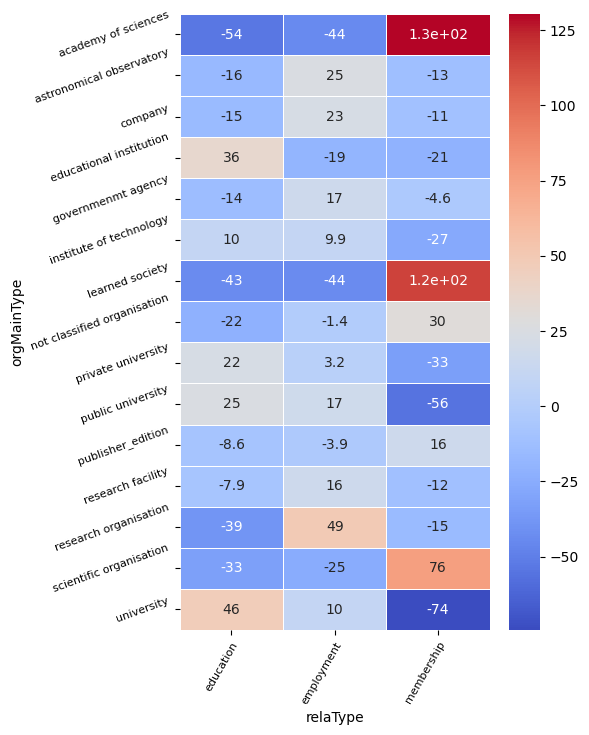

In [617]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

As said, we observe a strong relationship between these two variables which is explained by the fact that not all organisations types are concerned by the same relationship types

We also observe that some values should be corrected, like memberships in technical organisations that should be employments.

See the following example

In [618]:
pprint.pprint(list(df_p.loc[df_p.orgMainType.str.contains('techno') & df_p.relaType.str.contains('memb') ].items())[:6])

[('uriPer',
  39735    http://www.wikidata.org/entity/Q3511568
Name: uriPer, dtype: object),
 ('labelPer', 39735    Søren Absalon Larsen
Name: labelPer, dtype: object),
 ('birthYear', 39735    1871
Name: birthYear, dtype: int64),
 ('relaType', 39735    membership
Name: relaType, dtype: object),
 ('uriOrg',
  39735    http://www.wikidata.org/entity/Q1269766
Name: uriOrg, dtype: object),
 ('labelOrg',
  39735    Technical University of Denmark
Name: labelOrg, dtype: object)]


### Explore contingency table of relationships to organisations : periods, types of organisations

In [619]:


### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1800,1801-1850,1851-1900,1901-1920,1921-1940,1941-1960,1961-1980,1981-2000,Total
orgMainType,,,,,,,,,
academy of sciences,652,985,1429,1277,2141,1347,332,47,8210
astronomical observatory,18,60,166,119,127,159,88,41,778
company,5,6,83,116,167,144,74,35,630
educational institution,199,407,876,750,1056,859,446,128,4721
governmenmt agency,3,9,39,69,110,129,114,22,495
institute of technology,9,94,352,369,734,903,584,128,3173
learned society,389,605,949,756,1143,985,237,24,5088
not classified organisation,90,129,367,311,494,437,305,71,2204
private university,16,91,530,788,1490,1338,639,138,5030


In [620]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [621]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 7528.29 , dof : 98
p-value : 0.0
phi2 = inertie (variance totale) : 0.09624015810008181
Cramer:  0.1172543986991422


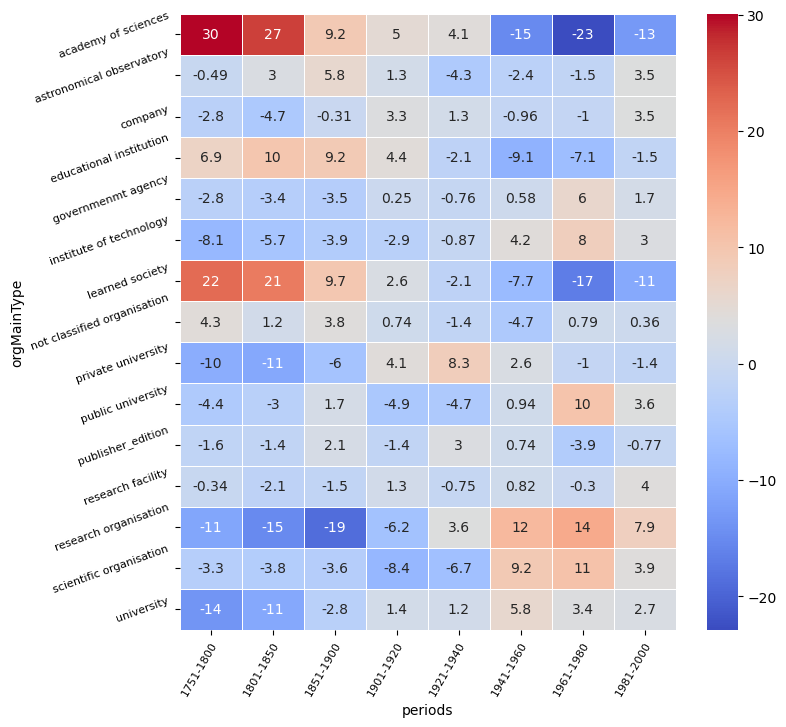

In [622]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [623]:


### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1800,1801-1850,1851-1900,1901-1920,1921-1940,1941-1960,1961-1980,1981-2000,Total
relaType,,,,,,,,,
education,464,1230,3908,4018,7231,7420,4054,969,29294
employment,460,1115,3826,4176,7300,8377,5019,1264,31537
membership,1106,1782,2934,2391,4157,3571,1271,181,17393
Total,2030,4127,10668,10585,18688,19368,10344,2414,78224


In [624]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [625]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 3626.88 , dof : 14
p-value : 0.0
phi2 = inertie (variance totale) : 0.046365352705067295
Cramer:  0.1522585838385923


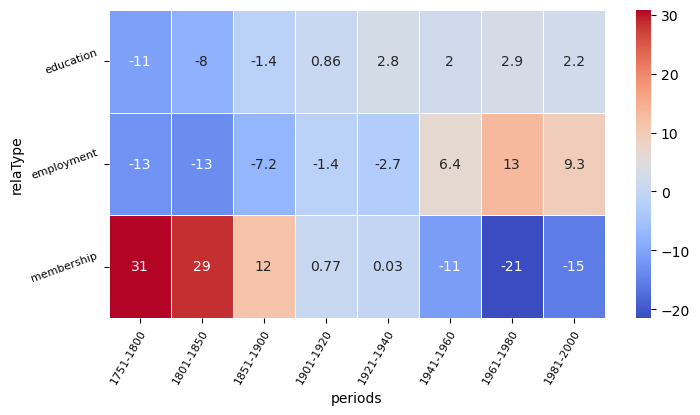

In [626]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [627]:
### Join on common organisation -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


421652


In [628]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [629]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

166664
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y
269,http://www.wikidata.org/entity/Q100216,Willi Kalender,1949,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,academy of sciences | learned society | nation...,learned society,membership,1941-1960,http://www.wikidata.org/entity/Q838330,University of Wisconsin–Madison,land-grant university | public educational ins...,university,education
273,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1960,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,membership
274,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1960,http://www.wikidata.org/entity/Q714717,Christ's College,college of the university of cambridge,university,education
275,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1960,http://www.wikidata.org/entity/Q466113,American Physical Society,learned society | open-access publisher | publ...,learned society,membership


In [630]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
education     29294
employment    31537
membership    17393
dtype: int64


In [631]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
8,membership,membership,25403
4,employment,employment,24786
1,education,employment,20323
3,employment,education,19878
5,employment,membership,19392
2,education,membership,16206
7,membership,employment,14150
0,education,education,13720
6,membership,education,12806


### Swap values in order to have the same orientation for all relationships

In [632]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [633]:
condition = merged.relaType_x > merged.relaType_y

In [634]:
### Transpose under condition

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [635]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y
269,http://www.wikidata.org/entity/Q100216,Willi Kalender,1949,http://www.wikidata.org/entity/Q838330,University of Wisconsin–Madison,academy of sciences | learned society | nation...,university,education,1941-1960,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,land-grant university | public educational ins...,learned society,membership
273,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1960,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,membership
274,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q714717,Christ's College,organization,university,education,1941-1960,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,college of the university of cambridge,not classified organisation,employment
275,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1960,http://www.wikidata.org/entity/Q466113,American Physical Society,learned society | open-access publisher | publ...,learned society,membership
276,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1960,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academic publisher | academy of sciences | pro...,academy of sciences,membership
277,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1960,http://www.wikidata.org/entity/Q217365,Bell Labs,privately held company | publisher | research ...,research organisation,employment
278,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1960,http://www.wikidata.org/entity/Q40358,American Association for the Advancement of Sc...,academic publisher | international organizatio...,scientific organisation,membership


In [636]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
1,education,employment,40201
4,employment,membership,33542
2,education,membership,29012
5,membership,membership,25403
3,employment,employment,24786
0,education,education,13720


In [637]:
### Concat relationships
merged['relaType_concat'] = merged.apply(lambda x: x.relaType_x + '_' +x.relaType_y, axis=1)

In [638]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,relaType_concat
269,http://www.wikidata.org/entity/Q100216,Willi Kalender,1949,http://www.wikidata.org/entity/Q838330,University of Wisconsin–Madison,academy of sciences | learned society | nation...,university,education,1941-1960,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,land-grant university | public educational ins...,learned society,membership,education_membership
273,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,organization,not classified organisation,employment,1941-1960,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,membership,employment_membership


In [639]:
df_graph=merged.groupby(['periods', 'relaType_concat', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x',  
                         'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
               as_index=False)\
    .agg({'labelPer': '|'.join, 'uriPer': '|'.join})

df_graph['number'] = df_graph.labelPer.apply(lambda x : len(x.split('|')))


In [640]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


117949


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
72936,1921-1940,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Michael Rossmann|Sidney Altman|Ludvig Faddeev|...,http://www.wikidata.org/entity/Q101728|http://...,268
99185,1941-1960,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Duncan Haldane|Joseph Incandela|John C. Mather...,http://www.wikidata.org/entity/Q1002250|http:/...,194
47401,1901-1920,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Andrew Huxley|Vitaly Ginzburg|Egon Orowan|Char...,http://www.wikidata.org/entity/Q104607|http://...,186
28747,1851-1900,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Jacobus Henricus van 't Hoff|Peter Debye|Henry...,http://www.wikidata.org/entity/Q102822|http://...,121
72764,1921-1940,membership_membership,http://www.wikidata.org/entity/Q2370801,Academy of Sciences of the USSR,academy of sciences,http://www.wikidata.org/entity/Q83172,Russian Academy of Sciences,academy of sciences,Ludvig Faddeev|Yuri Oganessian|David Pines|Spa...,http://www.wikidata.org/entity/Q1030228|http:/...,109


### Explore contingency table of relationship pairs to periods

In [641]:


### Contingency table
X = 'periods'
Y = 'relaType_concat'  

ddf = df_graph[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1800,1801-1850,1851-1900,1901-1920,1921-1940,1941-1960,1961-1980,1981-2000,Total
relaType_concat,,,,,,,,,
education_education,189,463,1657,1851,2662,2723,1724,411,11680
education_employment,411,1086,4546,5164,7475,8484,5497,1417,34080
education_membership,931,1657,3516,3040,4468,3569,1468,199,18848
employment_employment,188,656,3017,3445,4310,5531,3849,1066,22062
employment_membership,905,1865,4293,3518,4899,4326,1696,308,21810
membership_membership,878,1095,2184,1373,2029,1346,519,45,9469
Total,3502,6822,19213,18391,25843,25979,14753,3446,117949


In [642]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [643]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 8789.95 , dof : 35
p-value : 0.0
phi2 = inertie (variance totale) : 0.07452331959959418
Cramer:  0.1220846588229612


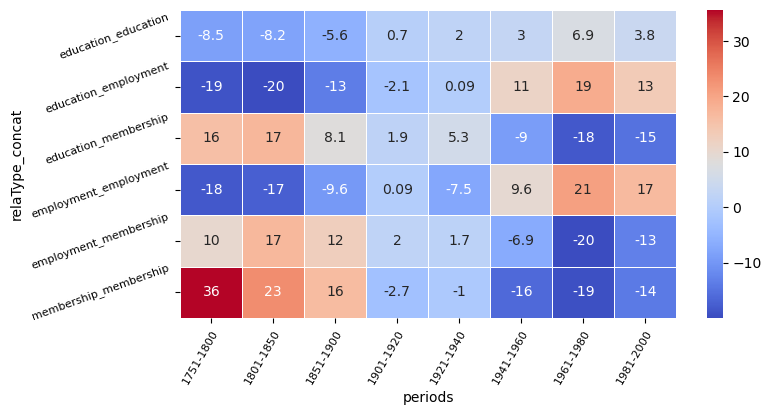

In [644]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Graph analysis


We will explore some aspects the relationships:

* which organisations are connected though education, but this will be only at the level of universities, not earlier education stage
* the same we will explore for memberships and employments, keeping them separated
* we will then ask what the relationship is between employment and membership
* and finally inspect if some kind of educational institutions (at unversity level, lead to specific employments or memberships)






### Organisations connected through higher education

In [645]:
print(df_mainTypes.mainType.to_list())

['university', 'public university', 'academy of sciences', 'learned society', 'private university', 'educational institution', 'research organisation', 'institute of technology', 'scientific organisation', 'not classified organisation', 'astronomical observatory', 'research facility', 'company', 'governmenmt agency', 'publisher_edition']


In [646]:
types_list=['university', 'public university', 'private university']

In [647]:
df_edu_graph = df_graph[(df_graph.relaType_concat == 'education_education') \
                     & (df_graph.orgMainType_x.isin(types_list)) \
                     & (df_graph.orgMainType_y.isin(types_list))  ]

print(len(df_edu_graph))
df_edu_graph.iloc[:2]

5945


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
22,1751-1800,education_education,http://www.wikidata.org/entity/Q12024650,Jesuit College and Church of Saint Ignatius,university,http://www.wikidata.org/entity/Q165980,University of Vienna,university,Franz Josef Gerstner,http://www.wikidata.org/entity/Q213783,1
23,1751-1800,education_education,http://www.wikidata.org/entity/Q12024650,Jesuit College and Church of Saint Ignatius,university,http://www.wikidata.org/entity/Q31519,Charles University,public university,Franz Josef Gerstner,http://www.wikidata.org/entity/Q213783,1


In [648]:
df_edu_graph.sort_values(by='number',ascending=False).iloc[:2]

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
48428,1921-1940,education_education,http://www.wikidata.org/entity/Q13164,Moscow State University,public university,http://www.wikidata.org/entity/Q2367144,MSU Faculty of Physics,university,Anatoly Sukhorukov|Mikhail Shumayev|Leonid Kel...,http://www.wikidata.org/entity/Q16510526|http:...,23
48427,1921-1940,education_education,http://www.wikidata.org/entity/Q13164,Moscow State University,public university,http://www.wikidata.org/entity/Q2367115,MSU Faculty of Mechanics and Mathematics,university,Valentin Esipov|Gary Gavrilov|Vladimir Arnold|...,http://www.wikidata.org/entity/Q112133335|http...,19


In [649]:
### Number of relationships by period
print(df_edu_graph.groupby('periods').size())

periods
1751-1800      58
1801-1850     186
1851-1900     794
1901-1920     910
1921-1940    1361
1941-1960    1438
1961-1980     960
1981-2000     238
dtype: int64


### Inspect a specific period

In [701]:
p = '1901-1920' #'1851-1900' #'1921-1940'

In [702]:
df_edu_graph_p = df_edu_graph[(df_edu_graph.periods==p)]
df_edu_graph_p.sort_values(by='number',ascending=False).head(2)

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
30899,1901-1920,education_education,http://www.wikidata.org/entity/Q3064332,Science Faculty of Paris,university,http://www.wikidata.org/entity/Q83259,École Normale Supérieure,public university,Jules Farineau|Louis Néel|Pierre Demers|Jean-F...,http://www.wikidata.org/entity/Q110702780|http...,8
31047,1901-1920,education_education,http://www.wikidata.org/entity/Q35794,University of Cambridge,university,http://www.wikidata.org/entity/Q691283,St John's College,university,Maurice Wilkins|Nevill Francis Mott|Charles Oa...,http://www.wikidata.org/entity/Q184659|http://...,7


In [703]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriOrg_x'], e['uriOrg_y'],
     {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
      ## the weight ist the number of persons in this relationship
      'weight':e['number']}
     )) 
     for e in df_edu_graph_p.to_dict(orient='records')]
print(len(l))

910


In [704]:
edu_graph_p=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
edu_graph_p.add_edges_from(l)

naf.basic_graph_properties(edu_graph_p)

### Create a list of graphs, one per component
edu_graph_p_S = [edu_graph_p.subgraph(c).copy() for c in nx.connected_components(edu_graph_p)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(edu_graph_p_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 430,
 'number_of_edges': 910,
 '------': '------',
 'is connected': False,
 'components': 14,
 'density': 0.009866102889358703}
[[0, 399], [1, 5], [2, 3], [7, 3], [3, 2]]


In [705]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

Just one big component


In [706]:
### Alternative way with just one graph
pG = edu_graph_p_S[0]
naf.basic_graph_properties(pG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 399,
 'number_of_edges': 892,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.01123411543935215}


In [707]:
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head(2)

,uriOrg,labelOrg,orgMainType,periods,period_members_number
13050,http://www.wikidata.org/entity/Q6867,International Astronomical Union,scientific organisation,1941-1960,621
13051,http://www.wikidata.org/entity/Q6867,International Astronomical Union,scientific organisation,1961-1980,442


In [708]:
df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


,uri,label,mainType,membersNumber
0,http://www.wikidata.org/entity/Q100148173,Samaldas Arts College,educational institution,1
7,http://www.wikidata.org/entity/Q1003730,Bulgarian Academy of Sciences,academy of sciences,9
11,http://www.wikidata.org/entity/Q1004412,Bulletin of the Atomic Scientists,publisher_edition,1
20,http://www.wikidata.org/entity/Q1007545,Galatasaray High School,educational institution,1
43,http://www.wikidata.org/entity/Q1010549,Bureau of Ships,governmenmt agency,1


In [709]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
## Add attributes
nx.set_node_attributes(pG, ln)
pprint.pprint(list(pG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q102398208',
  {'label': 'German University in Prague Medical School',
   'mainType': 'university',
   'membersNumber': 1}),
 ('http://www.wikidata.org/entity/Q102398283',
  {'label': 'faculty of science, German University in Prague',
   'mainType': 'university',
   'membersNumber': 11})]


In [710]:
mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
mn_s.groupby(by=mn_s).size().sort_values(ascending=False)


university            246
public university     113
private university     40
dtype: int64

####  Create dataframe and inspect node properties

In [711]:
### Eigenvector
le = list(nx.eigenvector_centrality(pG, 
                        max_iter=200, weight='weight').items())
nx.set_node_attributes(pG, dict(le), 'eigenvector')
pprint.pprint(list(pG.nodes.data())[:1])

[('http://www.wikidata.org/entity/Q102398208',
  {'eigenvector': 0.0005740240474229081,
   'label': 'German University in Prague Medical School',
   'mainType': 'university',
   'membersNumber': 1})]


In [712]:
### Betweenness
lb = list(nx.betweenness_centrality(pG, weight='weight').items())
nx.set_node_attributes(pG, dict(lb), 'betweenness')
pprint.pprint(list(pG.nodes.data())[:1])


[('http://www.wikidata.org/entity/Q102398208',
  {'betweenness': 0.0,
   'eigenvector': 0.0005740240474229081,
   'label': 'German University in Prague Medical School',
   'mainType': 'university',
   'membersNumber': 1})]


In [713]:
### Export node attributes to dataframe
nodes_data ={node: pG.nodes[node] for node in pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


,id,label,mainType,membersNumber,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q102398208,German University in Prague Medical School,university,1,0.000574,0.0
1,http://www.wikidata.org/entity/Q102398283,"faculty of science, German University in Prague",university,11,0.012561,0.01015


In [714]:
### List found on p. 121, some colors added
col_list = [
('university', 'DarkSeaGreen'), 
('public university', 'red'), 
('private university', 'DeepSkyBlue')
]
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'private university': 'DeepSkyBlue',
 'public university': 'red',
 'university': 'DarkSeaGreen'}


In [715]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point



    df=dataframe
    # df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.98]).item()
    test_v2 = df[value_2].quantile([0.98]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items()],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    # plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

0.15193072744602232 0.0797168604030122


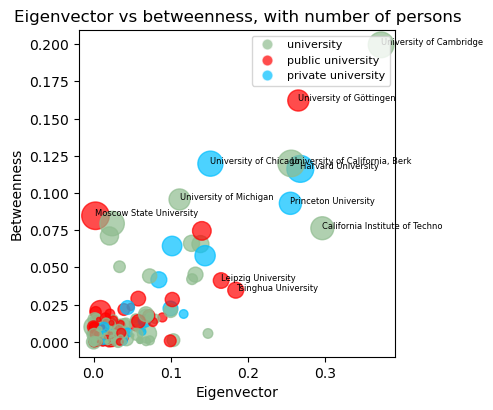

Spearman's rank correlation: 0.6107915693867197


In [716]:
compare_with_scatter_plot(nodes_df, 'eigenvector', 'betweenness', 'membersNumber', 
                          point_ratio=3, c_category='mainType',
                          color_map=color_map, figsize=(5,4), 
                          legend_loc='upper right', 
                          title='Eigenvector vs betweenness, with number of persons', 
                          n_label='label', label_cut_value='membersNumber' )

corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

In [717]:
list(nodes_df.columns)

['id', 'label', 'mainType', 'membersNumber', 'eigenvector', 'betweenness']

In [718]:
print('Betweenness')
pprint.pprint((nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))

Betweenness
                                 label            mainType membersNumber
25             University of Cambridge          university           114
2              University of Göttingen   public university            77
31  University of California, Berkeley          university           122
6                University of Chicago  private university           109
7                   Harvard University  private university           125
22              University of Michigan          university            76
89                Princeton University  private university            85

-----
Eigenvector
                                  label            mainType membersNumber
25              University of Cambridge          university           114
76   California Institute of Technology          university            91
7                    Harvard University  private university           125
2               University of Göttingen   public university            77
31   University

#### Plot graph

In [719]:
pict_addr = 'images/organisations/edu_edu_' + p +'.svg'
print(pict_addr)

images/organisations/edu_edu_1901-1920.svg


In [720]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=8, alpha=alpha_n
                        )
                        for label, color in color_map.items()],
                        loc='lower right', fontsize=8)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
plt.savefig(pict_addr)
#plt.show()
plt.close()


### Communitites

In [721]:
l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
print( len(l_communities))
sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
print([c[1] for c in sl_communities])
print(sl_communities[-1:])


10
[154, 76, 61, 32, 24, 18, 13, 10, 8, 3]
[({'http://www.wikidata.org/entity/Q1229996', 'http://www.wikidata.org/entity/Q539881', 'http://www.wikidata.org/entity/Q940302'}, 3)]


In [722]:
for i in range(0,5):
   print('\n\nCommunity '+ str(i), '\nBetweenness')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))
   print('\n-----\nEigenvector')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))




Community 0 
Betweenness
                     label            mainType membersNumber
6    University of Chicago  private university           109
7       Harvard University  private university           125
22  University of Michigan          university            76
89    Princeton University  private university            85

-----
Eigenvector
                                  label            mainType membersNumber
76   California Institute of Technology          university            91
7                    Harvard University  private university           125
89                 Princeton University  private university            85
111                 Tsinghua University   public university            44


Community 1 
Betweenness
                       label    mainType membersNumber
25   University of Cambridge  university           114
133     University of Vienna  university            57
150     University of London  university            23
234          Trinity College  un

#### Plot communitites graph

In [723]:
pict_addr_comm = 'images/organisations/edu_edu_communities_' + p +'.svg'
print(pict_addr_comm)

images/organisations/edu_edu_communities_1901-1920.svg


In [724]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]

node_colors = []
for n in g.nodes.data():
    if n[0] in list(sl_communities[0][0]):
        node_colors.append('red')
    elif n[0] in list(sl_communities[1][0]):
        node_colors.append('blue')
    elif n[0] in list(sl_communities[2][0]):
        node_colors.append('green')
    elif n[0] in list(sl_communities[3][0]):
        node_colors.append('orange')
    elif n[0] in list(sl_communities[4][0]):
        node_colors.append('maroon')
    else:
        node_colors.append('lightGrey')        


edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5



### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr_comm
plt.savefig(pict_addr)
#plt.show()
plt.close()


## Create general function

In [698]:
def generate_report_and_plots(df, concatRelaType, type_list, doc_addr, df_orgPeriod):

    with open(doc_addr, "w") as myfile:
        myfile.write('# Report for relations: ' + concatRelaType + '\n')


    df_g = df[(df.relaType_concat == concatRelaType) \
                     & (df.orgMainType_x.isin(type_list)) \
                     & (df.orgMainType_y.isin(type_list))  ]

    txt = str(df_g.groupby('periods').size())

    with open(doc_addr, "a") as myfile:
        myfile.write('\n'+txt + '\n')

    for p in df_g['periods'].unique():
        print(str(p))   

        with open(doc_addr, "a") as myfile:
            myfile.write('\n\n\n## Values for ' + p + '\n')

        df_g_p = df_g[df_g.periods==p]
        
        with open(doc_addr, "a") as myfile:
            myfile.write('\nNumber of relationships for this period ' + str(len(df_g_p)) + '\n')
        
        l = [tuple(
            (e['uriOrg_x'], e['uriOrg_y'],
            {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
            ## the weight ist the number of persons in this relationship
            'weight':e['number']}
            )) 
            for e in df_g_p.to_dict(orient='records')]
        
        graph_p=nx.Graph()
        graph_p.add_edges_from(l)

        txt = 'Number of nodes: ' + str(graph_p.number_of_nodes())+\
                '\nNumber of edges: ' + str(graph_p.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### Components
        graph_p_S = [graph_p.subgraph(c).copy() 
                     for c in nx.connected_components(graph_p)]

        ln = sorted([[i,len(s.nodes)] for i,s in enumerate(graph_p_S)], key = lambda row: row[1], reverse=True)
        try:
            if ln[1][1]*20 < ln[0][1]:
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nJust one big component with ' + str(graph_p_S[0].number_of_nodes()) + ' nodes\n')            
            else :
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nBeware: more than one big component !'  + '\n')
        except Exception as e:
             print(e)            
            
        ### Alternative way with just one graph
        pG = graph_p_S[0]

        txt = 'Number of nodes for first component: ' + str(pG.number_of_nodes())+\
                '\nNumber of edges for first component: ' + str(pG.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### No treatment for smaller graphs
        if int(pG.number_of_nodes()) > 30:

            ### Prepare data to add to nodes

            df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
            df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']

            ln = dict([(e['uri'],
                {'label':e['label'], 'mainType':e['mainType'],
                                    'membersNumber':e['membersNumber']}
                ) for e in df_opl.to_dict(orient='records')])
            ## Add attributes
            nx.set_node_attributes(pG, ln)

            mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
            txt= str(list(mn_s.groupby(by=mn_s).size().sort_values(ascending=False).items()))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            ### Eigenvector
            try:
                le = list(nx.eigenvector_centrality(pG, 
                                        max_iter=1000, weight='weight').items())
            except Exception as e:
                print(e)    
            nx.set_node_attributes(pG, dict(le), 'eigenvector')   

            ### Betweenness
            lb = list(nx.betweenness_centrality(pG, weight='weight').items())
            nx.set_node_attributes(pG, dict(lb), 'betweenness')


            ### Export node attributes to dataframe
            nodes_data ={node: pG.nodes[node] for node in pG.nodes}
            nodes_df = pd.DataFrame(nodes_data).T
            nodes_df.reset_index(inplace=True, names='id')

            corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
            txt = "Spearman's rank correlation of eidenvector and betweenness: {}".format(corr_spear.iloc[0,1])
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            txt = 'Eigenvector\n' + \
                str(nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7) )+\
                '\n-----\nBetweenness'+\
                str(nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')


            pict_addr = 'images/organisations/' + concatRelaType + '_' + p +'.svg'        


            ### Plot the graph
            g = pG
            # n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
            n_size = np.log(nx.number_of_nodes(g))*10

            graph_layout = 'spring_layout'
            n_k = np.log(nx.number_of_nodes(g))/20 #2.5

            ### Define the layout, i.e. the choice 
            # of the algorithm for the representation of the graph.

            if graph_layout == 'fruchterman_reingold':
                pos = nx.fruchterman_reingold_layout(g)
            elif graph_layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(g)
            elif graph_layout == 'spring_layout':
                pos = nx.spring_layout(g, k = n_k)  
            else:
                pos = nx.kamada_kawai_layout(g)

            # https://networkx.org/documentation/stable/reference/drawing.html
            plt.figure(figsize = (n_size,n_size))

            node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
            #node_size = [d[1]*100 for d in nx.degree(g)]
            #node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

            edge_size = [e[2]['weight'] for e in g.edges.data()]
            edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

            node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


            nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='blue', alpha=0.6)
            nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
            nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
            #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

            alpha_n=0.5

            plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                    label=label, markerfacecolor=color, 
                                    markersize=8, alpha=alpha_n
                                    )
                                    for label, color in color_map.items()],
                                    loc='lower right', fontsize=8)


            ### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
            plt.tight_layout(pad=60)
            pict_addr = pict_addr
            plt.savefig(pict_addr)
            #plt.show()
            plt.close()


            ### Identify communitites
            l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
            sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
            txt= 'Number of communitites: ' + str(len(l_communities)) +\
                    '\nNumber of nodes per community: ' + str([c[1] for c in sl_communities])
            with open(doc_addr, "a") as myfile:
                myfile.write('\n'+ txt  + '\n')

            communities_print = 'Communities: \n'
            try:
                for i in range(0,5):
                    communities_print += '\n\nCommunity '+ str(i) + '\nBetweenness'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ]\
                                                .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                    communities_print += '\n-----\nEigenvector'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ communities_print  + '\n')
            except Exception as e:
                 print(e)        

        else:
            print('Too small graph to be analyzed!')        


In [699]:
print(df_mainTypes.mainType.to_list())

['university', 'public university', 'academy of sciences', 'learned society', 'private university', 'educational institution', 'research organisation', 'institute of technology', 'scientific organisation', 'not classified organisation', 'astronomical observatory', 'research facility', 'company', 'governmenmt agency', 'publisher_edition']


In [700]:
relationship_type = 'education_education'
generate_report_and_plots(df_graph, relationship_type,
                           ['university','public university','private university'],
                           'analysis_doc/'+relationship_type+'.md',
                           df_orgPeriod)

1751-1800
Too small graph to be analyzed!
1801-1850
Too small graph to be analyzed!
1851-1900
1901-1920
1921-1940
1941-1960
1961-1980
1981-2000


In [602]:
relationship_type = 'membership_membership'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

1751-1800
list index out of range
1801-1850
1851-1900
1901-1920
1921-1940
1941-1960
1961-1980
1981-2000
Too small graph to be analyzed!


In [725]:
relationship_type = 'employment_employment'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

1751-1800
Too small graph to be analyzed!
1801-1850
1851-1900
1901-1920
1921-1940
1941-1960
Too small graph to be analyzed!
1961-1980
1981-2000
